In [335]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
import os
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from config_parameters import DATA_TABLE_FILE, SUMMARY_SIMULATIONS_FILE, STRATEGIES_TABLE_FILE, SIMULATION_DATA_DICT, LOGS_FOLDER


# === 1. Wczytaj dane ===
dane_gieldowe = pd.read_excel(DATA_TABLE_FILE)

start_date = "2021-11-01"  # "2021-11-01"
end_date = "2025-03-01"
start_test_date="2024-02-01"



simulation_data_dir=SIMULATION_DATA_DICT
simulation_data_specific = os.path.join(simulation_data_dir, f"{start_date}_to_{end_date}")
#2023-08-01
all_training_preprocessed_path = "all_training_preprocessed.feather"



intervals=['1w', '3d','2d', '1d', '12h', '6h', '4h', '2h', '1h', '30m', '15m']
intervals=[ '12h', '6h', '4h', '2h', '1h']
intervals=[ '4h', '2h', '1h','30m', '15m']
intervals=['12h', '6h', '4h', '2h', '1h', '30m', '15m']
type="L"
strategy="2.3"
min_profit=1
commission=0.002
load_data=False
tp_signal_or_sl_predict=True

scaler_distance=MinMaxScaler()

#category_choose="CRYPTO"
# Lista do przechowania danych


 # for strategies porównuje wyniki modelu
def add_range_features(df, target_df, col_name, ranges, prefix):
    """
    Dodaje do target_df kolumny binarne na podstawie przedziałów wartości z df[col_name].

    Parametry:
    - df: DataFrame źródłowy (np. train_df)
    - target_df: DataFrame, do którego mają być dodane nowe kolumny (np. X_train)
    - col_name: nazwa kolumny w df, której dotyczą przedziały
    - ranges: lista tupli (dolna_granica, górna_granica) lub 'lt'/'gt' dla wartości skrajnych
    - prefix: prefix nazw nowych kolumn
    """
    series = df[col_name]

    for r in ranges:
        if isinstance(r, str):  # np. 'lt_30' lub 'gt_80'
            if 'lt_' in r:
                val = float(r.replace('lt_', ''))
                col = f'{prefix}_lt_{int(val)}'
                condition = series < val
            elif 'gt_' in r:
                val = float(r.replace('gt_', ''))
                col = f'{prefix}_gt_{int(val)}'
                condition = series > val
            else:
                raise ValueError(f'Nieznany zakres: {r}')
        else:
            low, high = r
            col = f'{prefix}_{int(low)}_{int(high)}'
            condition = (series >= low) & (series < high)
        
        target_df[col] = condition.astype(int)

def add_normalized_ema_distance_feature(df, target_df, ema_periods, is_test=False, prefix='norm_ema_dist', close_col='close at entry', atr_col='ATR at entry'):
    """
    Dodaje znormalizowaną cechę: odległość między 'close' a EMA, przeskalowaną przez ATR i znormalizowaną.
    
    Parametry:
    - df: DataFrame źródłowy (np. train_df)
    - target_df: DataFrame, do którego dodajemy kolumnę wynikową (np. X_train)
    - ema_periods: lista int, np. [20, 50, 100]
    - close_col: kolumna ceny
    - atr_col: kolumna z ATR
    - prefix: nazwa kolumny wynikowej
    """
    total_dist = np.zeros(df.shape[0])  # zamiast len(df) – gwarantuje działanie

    for period in ema_periods:
        ema_col = f'EMA_{period} at entry'
        if ema_col in df.columns:
            distance = np.log1p(np.abs(df[close_col] - df[ema_col]) / df[atr_col])
            total_dist += np.sqrt(distance)
        else:
            print(f"⚠️ Kolumna {ema_col} nie istnieje w danych!")

    # Upewnij się, że total_dist to ndarray
    total_dist = np.array(total_dist).reshape(-1, 1)

    # Normalizacja
    if is_test:
        normalized = scaler_distance.transform(total_dist).flatten()
    else:
        normalized = scaler_distance.fit_transform(total_dist).flatten()

    target_df[prefix] = normalized



def create_X(train_df, is_test=False):

    X_train = pd.DataFrame()
# Wybór istniejących kolumn
# X['MACD'] = df['MACD at entry']

    # add_normalized_ema_distance_feature(
    #     df=train_df,
    #     target_df=X_train,
    #     ema_periods=[20, 50, 100],
    #     is_test=is_test,
    #     prefix="norm_short_ema_distance"
    # )

    # #add_normalized_ema_distance_feature(
    #     df=train_df,
    #     target_df=X_train,
    #     ema_periods=[200, 500, 595]  , 
    #     is_test=is_test,
    #     prefix="norm_long_ema_distance"

    # )

    add_range_features(train_df, X_train, 'RSI at entry', ['lt_30', (30, 40), (40, 50), (50, 65), (65, 75)], 'RSI')


    add_range_features(
        train_df,
        X_train,
        'Williams_%R at entry',
        ['lt_-80', (-80, -60), (-60, -40), (-40, -20)],
        'William'
    )

    add_range_features(
        train_df,
        X_train,
        'K at entry',
        ['lt_20', (20, 50), (50, 70), (70, 90)],
        'K'
    )
    add_range_features(
        train_df,
        X_train,
        'D at entry',
        ['lt_20', (20, 50), (50, 70), (70, 90)],
        'D'
    )



    #X['RSI_gt_75']      = (df['RSI at entry'] > 75).astype(int)
    X_train['SMA20>SMA100']=(train_df['SMA_20 at entry'] > train_df['SMA_100 at entry']).astype(int)
    #X['SMA20>SMA500']=(df['SMA_20 at entry'] > df['SMA_500 at entry']).astype(int)


    X_train['EMA20>EMA50']=(train_df['EMA_20 at entry'] > train_df['EMA_50 at entry']).astype(int)
    X_train['EMA10>SMA20']=(train_df['EMA_10 at entry'] > train_df['SMA_100 at entry']).astype(int)
    X_train['EMA10>SMA100']=(train_df['EMA_10 at entry'] > train_df['SMA_100 at entry']).astype(int)
    X_train['EMA20>SMA150']=(train_df['EMA_20 at entry'] > train_df['SMA_150 at entry']).astype(int)
    X_train['if_SMA_500'] = (train_df['close at entry'] > train_df['SMA_500 at entry']).astype(int)
    X_train['if_SMA_200'] = (train_df['close at entry'] > train_df['SMA_200 at entry']).astype(int)
    X_train['if_SMA_150'] = (train_df['close at entry'] > train_df['SMA_150 at entry']).astype(int)
    X_train['if_SMA_100'] = (train_df['close at entry'] > train_df['SMA_100 at entry']).astype(int)
    X_train['if_EMA_20'] = (train_df['close at entry'] > train_df['EMA_20 at entry']).astype(int)


    return X_train


def create_dataset(dane_gieldowe,category_choose, simulation_data_dir ):
    dfs = []
    for index, row in dane_gieldowe.iterrows():

        ticker = row['Ticker']
        category=row["Category"]
        if category != category_choose:
            continue

        for interval in intervals:
            trades_path = f'{simulation_data_dir}/{ticker} - strategy {strategy}, interval {interval} - trades.xlsx'
            if os.path.exists(trades_path):
                df = pd.read_excel(trades_path)
                df['Ticker'] = ticker
                df['Interval'] = interval
                dfs.append(df)
            else:
                print(f"Brak pliku: {trades_path}")
    # Łączenie wszystkich DataFrame w jeden
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

    # === 2. Przygotuj dane ===






def get_training_data(path, dane_gieldowe,category_choose, simulation_data_dir):
    if os.path.exists(path) and load_data:
        df = pd.read_feather(path)
        
        if not df.empty:
            print("✅ Plik istnieje i zawiera dane.")
            print(df.head())  # podgląd pierwszych wierszy
        else:
            print("⚠️ Plik istnieje, ale jest pusty. Pobieram dane.")
            df=create_dataset(dane_gieldowe,category_choose, simulation_data_dir )
    else:
        print("❌ Plik nie istnieje. Pobieram dane.")
        df=create_dataset(dane_gieldowe,category_choose, simulation_data_dir )
        df.to_feather(path)
    return df

def Process_DataFrame(df,commission, min_profit, is_tp_signal_or_sl_predict):
    
    df = df.copy()
    df['P&L without_estimated_fees']=df['P&L']  - commission*df['Deposit']
    if is_tp_signal_or_sl_predict:

        df['profit'] = df['Result'].apply(lambda x: 0 if x == 'SL' else 1 if x in ['TP', 'SIGNAL'] else None)

    else:
        
        df['profit'] = (df['P&L without_estimated_fees'] > min_profit).astype(int)

    df['result_profit'] = df['P&L without_estimated_fees']
    df['Entry Time'] = pd.to_datetime(df['Entry Time'])

    df = df[df['Type'] == type]
    return df




df_All=get_training_data(all_training_preprocessed_path, dane_gieldowe,category_choose, simulation_data_specific)
cutoff_date = pd.to_datetime(start_test_date)


❌ Plik nie istnieje. Pobieram dane.
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/ADA - strategy 2.3, interval 30m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/ADA - strategy 2.3, interval 15m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/AIXBT - strategy 2.3, interval 30m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/AIXBT - strategy 2.3, interval 15m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/API3 - strategy 2.3, interval 30m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/API3 - strategy 2.3, interval 15m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/ARB - strategy 2.3, interval 30m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/ARB - strategy 2.3, interval 15m - trades.xlsx
Brak pliku: output_simulations\2021-11-01_to_2025-03-01/AUCTION - strategy 2.3, interval 30m - trades.xlsx
Brak pliku: output_simulati

In [336]:
print(df_All)

     Type         Create Time          Entry Time  Entry Price  \
0       L 2021-11-03 00:00:00 2021-11-03 12:00:00        2.116   
1       L 2021-11-03 12:00:00 2021-11-04 00:00:00        2.063   
2       L 2021-11-11 00:00:00 2021-11-11 12:00:00        2.127   
3       L 2021-11-15 00:00:00 2021-11-15 12:00:00        2.075   
4       L 2021-12-02 00:00:00 2021-12-02 12:00:00        1.663   
...   ...                 ...                 ...          ...   
7849    L 2024-12-27 01:00:00 2024-12-27 02:00:00        5.798   
7850    L 2025-01-13 21:00:00 2025-01-13 22:00:00        4.258   
7851    L 2025-01-15 13:00:00 2025-01-15 14:00:00        4.535   
7852    L 2025-02-16 09:00:00 2025-02-16 10:00:00        2.991   
7853    L 2025-02-16 12:00:00 2025-02-16 13:00:00        2.997   

               Exit Time  Exit Price  Stop_loss  Take_profit  Result  \
0    2021-11-03 12:00:00    2.084388   2.084388     2.366388      SL   
1    2021-11-04 00:00:00    2.017000   1.975458     2.366246  S

In [337]:

df_Training = df_All[df_All['Entry Time'] < cutoff_date]



df_Training_processed=Process_DataFrame(df_Training,commission, min_profit, tp_signal_or_sl_predict)



print(df_Training_processed)
y_train = df_Training_processed['profit']    # target_col np. 'profit'

print(y_train)
df_profit = df_Training_processed[['result_profit']].copy()


X_train=create_X(df_Training_processed, is_test=False)
X=X_train.copy()

X_train = X_train.fillna(0)
y_train = y_train.fillna(0)







     Type         Create Time          Entry Time  Entry Price  \
0       L 2021-11-03 00:00:00 2021-11-03 12:00:00        2.116   
1       L 2021-11-03 12:00:00 2021-11-04 00:00:00        2.063   
2       L 2021-11-11 00:00:00 2021-11-11 12:00:00        2.127   
3       L 2021-11-15 00:00:00 2021-11-15 12:00:00        2.075   
4       L 2021-12-02 00:00:00 2021-12-02 12:00:00        1.663   
...   ...                 ...                 ...          ...   
7699    L 2023-12-26 10:00:00 2023-12-26 11:00:00        3.753   
7700    L 2024-01-04 14:00:00 2024-01-04 15:00:00        3.164   
7701    L 2024-01-06 16:00:00 2024-01-06 17:00:00        2.841   
7702    L 2024-01-15 08:00:00 2024-01-15 09:00:00        2.762   
7703    L 2024-01-23 22:00:00 2024-01-23 23:00:00        2.217   

               Exit Time  Exit Price  Stop_loss  Take_profit  Result  \
0    2021-11-03 12:00:00    2.084388   2.084388     2.366388      SL   
1    2021-11-04 00:00:00    2.017000   1.975458     2.366246  S

In [338]:
print(y_train)

0       0.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
7699    1.0
7700    0.0
7701    1.0
7702    1.0
7703    1.0
Name: profit, Length: 4332, dtype: float64


In [339]:
model = RandomForestClassifier(n_estimators=250,max_features='sqrt' ,class_weight={0: 1, 1: (y_train.value_counts()[0])/y_train.value_counts()[1]} , random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 0.37523809523809526},
                       n_estimators=250, random_state=42)

In [340]:
# dfs=[]
# for index, row in dane_gieldowe.iterrows():

#     ticker = row['Ticker']
#     ticker_plik = row['Plik']
#     category=row["Category"]
#     if category != category_choose:
#         continue

#     for interval in intervals:
#         trades_path = f'{simulation_data_dir}/{start_test_date}/{ticker}- strategy {strategy}, interval {interval} - trades .xlsx'
#         if os.path.exists(trades_path):
#             try:
#                 df = pd.read_excel(trades_path)
#                 df['Ticker'] = ticker
#                 df['Interval'] = interval
#                 dfs.append(df)
#             except Exception as e:
#                 print("❌ Błąd podczas wczytywania:", e)
#         else:
#             print(f"Brak pliku: {trades_path}")
#          combined_df = pd.concat(dfs, ignore_index=True)
 # Looking for data from df_All, not other files
combined_df = df_All[df_All['Entry Time'] > cutoff_date]
# Łączenie wszystkich DataFrame w jeden


# === 2. Przygotuj dane ===
df = combined_df[combined_df['Type'] == type].copy().reset_index()


# Dodaj etykietę celu: 1 = zysk, 0 = strata


if tp_signal_or_sl_predict:

    df['profit'] = df['Result'].apply(lambda x: 0 if x in ['SL', 'END'] else 1 if x in ['TP', 'SIGNAL'] else None)

else:
    
    df['profit'] = (df['P&L without_estimated_fees'] > min_profit).astype(int)

#df['result_profit'] = df['P&L without_estimated_fees']



df['P&L without_estimated_fees']=(df['P&L']  - commission*df['Deposit']*100)
#df['profit'] = (df['P&L without_estimated_fees'] > min_profit).astype(int)


df['Entry Time'] = pd.to_datetime(df['Entry Time'])
df.to_excel("TEST.xlsx")
X_test= create_X(df, is_test=True)
X_test = X_test.fillna(0)
y_test = df['profit']


In [341]:
df['Result'].value_counts()

Result
SIGNAL    2219
SL         986
TP         315
END          2
Name: count, dtype: int64

In [342]:
print(y_test)
print(y_test.isna().sum())

0       0
1       1
2       1
3       0
4       1
       ..
3517    1
3518    1
3519    1
3520    1
3521    0
Name: profit, Length: 3522, dtype: int64
0


2024-02-01
Classification Report for train:
              precision    recall  f1-score   support

         0.0       0.49      0.76      0.60      1182
         1.0       0.89      0.70      0.78      3150

    accuracy                           0.72      4332
   macro avg       0.69      0.73      0.69      4332
weighted avg       0.78      0.72      0.73      4332

Classification Report for test:
              precision    recall  f1-score   support

           0       0.38      0.55      0.45       988
           1       0.79      0.64      0.71      2534

    accuracy                           0.62      3522
   macro avg       0.58      0.60      0.58      3522
weighted avg       0.67      0.62      0.63      3522



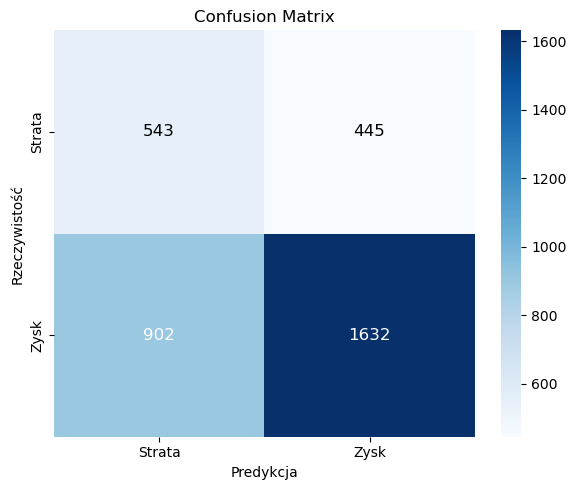

Index(['RSI_lt_30', 'RSI_30_40', 'RSI_40_50', 'RSI_50_65', 'RSI_65_75',
       'William_lt_-80', 'William_-80_-60', 'William_-60_-40',
       'William_-40_-20', 'K_lt_20', 'K_20_50', 'K_50_70', 'K_70_90',
       'D_lt_20', 'D_20_50', 'D_50_70', 'D_70_90', 'SMA20>SMA100',
       'EMA20>EMA50', 'EMA10>SMA20', 'EMA10>SMA100', 'EMA20>SMA150',
       'if_SMA_500', 'if_SMA_200', 'if_SMA_150', 'if_SMA_100', 'if_EMA_20'],
      dtype='object')
27
[0.         0.         0.10775646 0.06957549 0.03713476 0.01457743
 0.0331886  0.04852874 0.0629678  0.01592733 0.03142317 0.03710574
 0.04918344 0.02084144 0.03758197 0.03807067 0.04299439 0.0248233
 0.04664311 0.01817117 0.01424697 0.03542891 0.08872579 0.05447497
 0.0319378  0.03869054 0.        ]
27


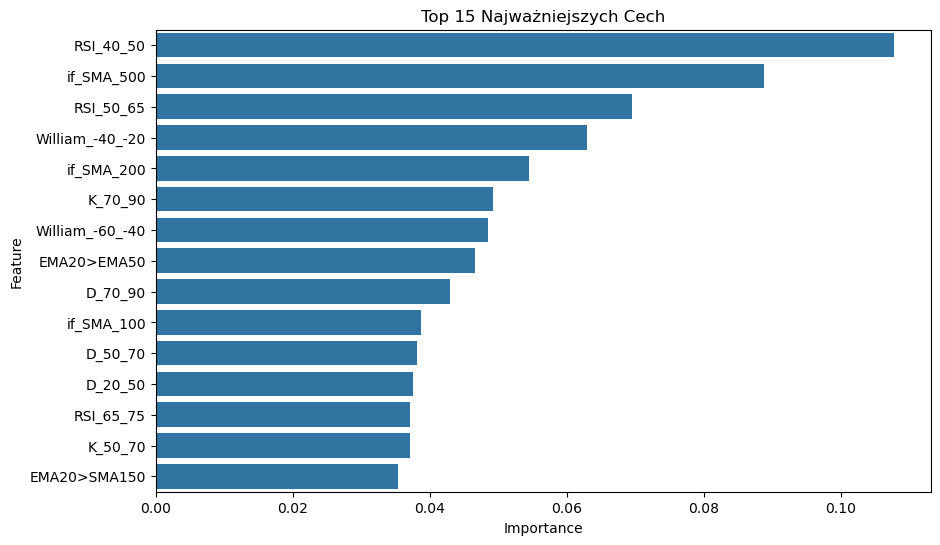

In [343]:
print(start_test_date)
y_pred= model.predict(X_train)
print("Classification Report for train:")
print(classification_report(y_train, y_pred))

y_pred = model.predict(X_test)
print("Classification Report for test:")
print(classification_report(y_test, y_pred))

# === 5. Macierz pomyłek ===

confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Tworzenie wykresu bez automatycznych anotacji
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=['Strata', 'Zysk'], yticklabels=['Strata', 'Zysk'])

# Ręczne wypisanie wartości z kontrolą koloru
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=color, fontsize=12)

plt.xlabel('Predykcja')
plt.ylabel('Rzeczywistość')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === 6. Ważność cech ===

importances = model.feature_importances_
feature_names = X.columns
print(feature_names)
print(len(feature_names))
print(importances)
print(len(importances))
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Najważniejszych Cech")
plt.show()

In [344]:
#X_test_reset = X_test.reset_index(drop=True)
#y_test_reset = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name='y_pred')

# Łączenie danych
results_df = pd.concat([X_test, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela

print(results_df)
results_df.to_excel("porownanie_predykcji.xlsx", index=False)

print("Plik 'porownanie_predykcji.xlsx' został zapisany.")

      RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0             0          0          0          1          0               0   
1             0          0          0          1          0               0   
2             0          0          0          1          0               0   
3             0          0          0          1          0               0   
4             0          0          1          0          0               0   
...         ...        ...        ...        ...        ...             ...   
3517          0          0          1          0          0               0   
3518          0          0          1          0          0               0   
3519          0          0          0          1          0               0   
3520          0          0          1          0          0               0   
3521          0          0          1          0          0               0   

      William_-80_-60  William_-60_-40  William_-40

In [345]:
print(results_df)

      RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0             0          0          0          1          0               0   
1             0          0          0          1          0               0   
2             0          0          0          1          0               0   
3             0          0          0          1          0               0   
4             0          0          1          0          0               0   
...         ...        ...        ...        ...        ...             ...   
3517          0          0          1          0          0               0   
3518          0          0          1          0          0               0   
3519          0          0          0          1          0               0   
3520          0          0          1          0          0               0   
3521          0          0          1          0          0               0   

      William_-80_-60  William_-60_-40  William_-40

In [346]:
X_test2 = X_test.copy()
X_test2['P&L without_estimated_fees'] = df.loc[X_test.index, 'P&L without_estimated_fees']
y_pred_series = pd.Series(y_pred, name='y_pred', index=X_test2.index)
results_df = pd.concat([X_test2, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela
results_df.to_excel("porownanie_predykcji.xlsx", index=False)
print("Plik 'porownanie_predykcji.xlsx' został zapisany.")
print(results_df)

Plik 'porownanie_predykcji.xlsx' został zapisany.
      RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0             0          0          0          1          0               0   
1             0          0          0          1          0               0   
2             0          0          0          1          0               0   
3             0          0          0          1          0               0   
4             0          0          1          0          0               0   
...         ...        ...        ...        ...        ...             ...   
3517          0          0          1          0          0               0   
3518          0          0          1          0          0               0   
3519          0          0          0          1          0               0   
3520          0          0          1          0          0               0   
3521          0          0          1          0          0               0   

 

In [347]:
pnl_suma = results_df.groupby('y_pred')['P&L without_estimated_fees'].sum()

# Wyświetlenie wyników
print("Suma P&L dla y_pred == 0:", pnl_suma.get(0, 0))
print("Suma P&L dla y_pred == 1:", pnl_suma.get(1, 0))

Suma P&L dla y_pred == 0: -5588.906415677352
Suma P&L dla y_pred == 1: -7008.213776803206


In [348]:
grouped = results_df.groupby('y_pred')['P&L without_estimated_fees'].agg(['sum', 'count'])

# Obliczanie średniej
grouped['mean'] = grouped['sum'] / grouped['count']

# Wyświetlenie wyników
print("Średnia P&L dla y_pred == 0:", grouped.loc[0, 'mean'] if 0 in grouped.index else 0)
print("Średnia P&L dla y_pred == 1:", grouped.loc[1, 'mean'] if 1 in grouped.index else 0)

Średnia P&L dla y_pred == 0: -3.8677553049670257
Średnia P&L dla y_pred == 1: -3.374200181417047


In [349]:
from sklearn.metrics import precision_score

y_proba = model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_proba >= 0.65).astype(int)  # zwiększ próg np. do 0.7

precision = precision_score(y_test, y_pred_adjusted)
print("Adjusted precision for class 1:", precision)

Adjusted precision for class 1: 0.7906647807637907


Classification Report for test:
              precision    recall  f1-score   support

           0       0.33      0.70      0.45       988
           1       0.79      0.44      0.57      2534

    accuracy                           0.51      3522
   macro avg       0.56      0.57      0.51      3522
weighted avg       0.66      0.51      0.53      3522



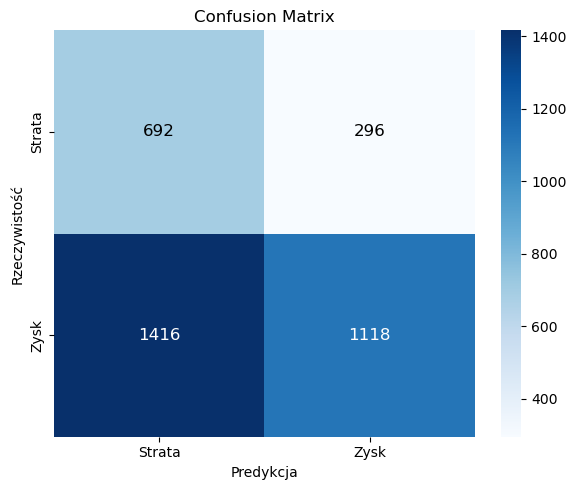

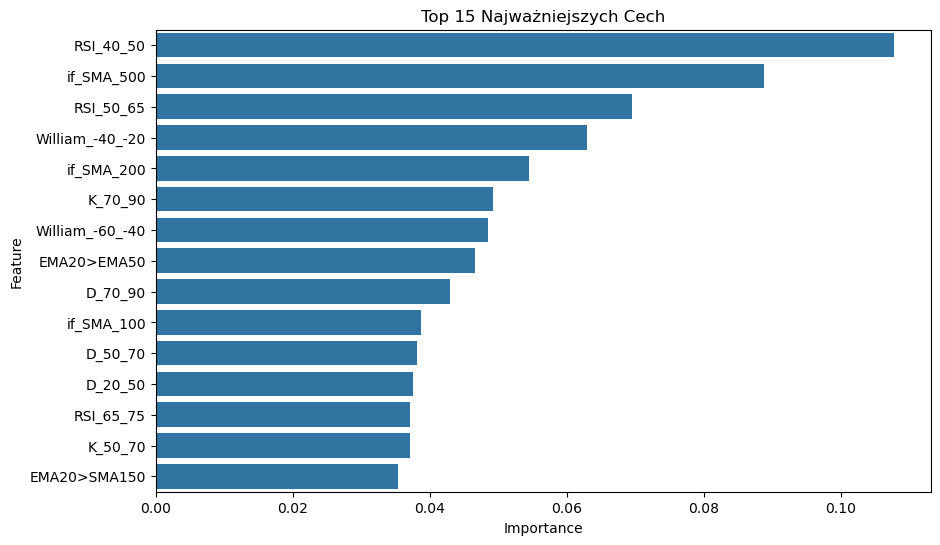

In [350]:


y_pred = y_pred_adjusted
print("Classification Report for test:")
print(classification_report(y_test, y_pred))

# === 5. Macierz pomyłek ===

confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Tworzenie wykresu bez automatycznych anotacji
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=['Strata', 'Zysk'], yticklabels=['Strata', 'Zysk'])

# Ręczne wypisanie wartości z kontrolą koloru
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=color, fontsize=12)

plt.xlabel('Predykcja')
plt.ylabel('Rzeczywistość')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === 6. Ważność cech ===

importances = model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Najważniejszych Cech")
plt.show()

In [351]:
#X_test_reset = X_test.reset_index(drop=True)
#y_test_reset = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name='y_pred')

# Łączenie danych
results_df = pd.concat([X_test, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela

print(results_df)
results_df.to_excel("porownanie_predykcji.xlsx", index=False)

print("Plik 'porownanie_predykcji.xlsx' został zapisany.")

      RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0             0          0          0          1          0               0   
1             0          0          0          1          0               0   
2             0          0          0          1          0               0   
3             0          0          0          1          0               0   
4             0          0          1          0          0               0   
...         ...        ...        ...        ...        ...             ...   
3517          0          0          1          0          0               0   
3518          0          0          1          0          0               0   
3519          0          0          0          1          0               0   
3520          0          0          1          0          0               0   
3521          0          0          1          0          0               0   

      William_-80_-60  William_-60_-40  William_-40

In [352]:
X_test2 = X_test.copy()
X_test2['P&L without_estimated_fees'] = df.loc[X_test.index, 'P&L without_estimated_fees']
y_pred_series = pd.Series(y_pred, name='y_pred', index=X_test2.index)
results_df = pd.concat([X_test2, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela
results_df.to_excel("porownanie_predykcji.xlsx", index=False)
print("Plik 'porownanie_predykcji.xlsx' został zapisany.")
print(results_df)

Plik 'porownanie_predykcji.xlsx' został zapisany.
      RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0             0          0          0          1          0               0   
1             0          0          0          1          0               0   
2             0          0          0          1          0               0   
3             0          0          0          1          0               0   
4             0          0          1          0          0               0   
...         ...        ...        ...        ...        ...             ...   
3517          0          0          1          0          0               0   
3518          0          0          1          0          0               0   
3519          0          0          0          1          0               0   
3520          0          0          1          0          0               0   
3521          0          0          1          0          0               0   

 

In [353]:
X_test2 = X_test.copy()
X_test2['P&L without_estimated_fees'] = df.loc[df.index, 'P&L without_estimated_fees']
y_pred_series = pd.Series(y_pred, name='y_pred', index=X_test2.index)
results_df = pd.concat([X_test2, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela
results_df.to_excel("porownanie_predykcji.xlsx", index=False)
print("Plik 'porownanie_predykcji.xlsx' został zapisany.")
print(results_df)

Plik 'porownanie_predykcji.xlsx' został zapisany.
      RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0             0          0          0          1          0               0   
1             0          0          0          1          0               0   
2             0          0          0          1          0               0   
3             0          0          0          1          0               0   
4             0          0          1          0          0               0   
...         ...        ...        ...        ...        ...             ...   
3517          0          0          1          0          0               0   
3518          0          0          1          0          0               0   
3519          0          0          0          1          0               0   
3520          0          0          1          0          0               0   
3521          0          0          1          0          0               0   

 

In [354]:
pnl_suma = results_df.groupby('y_pred')['P&L without_estimated_fees'].sum()

# Wyświetlenie wyników
print("Suma P&L dla y_pred == 0:", pnl_suma.get(0, 0))
print("Suma P&L dla y_pred == 1:", pnl_suma.get(1, 0))

Suma P&L dla y_pred == 0: -8857.33411470431
Suma P&L dla y_pred == 1: -3739.7860777762467


In [355]:
grouped = results_df.groupby('y_pred')['P&L without_estimated_fees'].agg(['sum', 'count'])

# Obliczanie średniej
grouped['mean'] = grouped['sum'] / grouped['count']

# Wyświetlenie wyników
print("Średnia P&L dla y_pred == 0:", grouped.loc[0, 'mean'] if 0 in grouped.index else 0)
print("Średnia P&L dla y_pred == 1:", grouped.loc[1, 'mean'] if 1 in grouped.index else 0)

Średnia P&L dla y_pred == 0: -4.201771401662386
Średnia P&L dla y_pred == 1: -2.6448274948912633
